In [3]:
import MDAnalysis as mda
import numpy as np
import os
from utils import *
import warnings 
import matplotlib.pyplot as plt

# Suppress warnings specific to MDAnalysis
warnings.filterwarnings("ignore", category=UserWarning, module="MDAnalysis")
# read in each of the substrate files
directory = 'substrates_initial/'
file_names = [f for f in os.listdir(directory)]
file_names = [str(i)+'.pdb' for i in range(0,10)]

# Defined in the array below are the distances away from ThDP atoms to substrate atoms 
# determine by the optimized structure of substrate 6 and are used to place the aka head atoms
# radii are in order of (columns) C1, N1, N2, S1 and then rows (C2, C3, O1) 
# so C1 is (0,0) Angstroms away from C2. All distances in Angstroms  
radii = [
    [1.539,2.562,3.389,2.880],
    [2.533,3.205,4.764,3.784],
    [2.393,2.973,2.592,3.893]]
# target angles represents the optimized angles of C1-C2-R ,O1-C2-R ,C3-C2-R
# we will use these to help us reposition the R group first atom 
target_angles = [111.1,110.2,107.5]
# load receptor universe and extract the different parts of the protein int1 receptor 
head_dir = '5EJ5/'
receptor = mda.Universe(head_dir+'5EJ5_receptor.pdb')

output_dir = '/Users/gbonn/OneDrive - Northwestern University/Bonnanzio Geoffrey/04 Raw Data/5EJ5/TEST_WORKFLOW/int1/'

# output the ThDP cofactor
ThDP = receptor.select_atoms("resname TPP")
write_universe(output_dir +'receptor/','TPP.pdb',ThDP)

# output just the protein and edit the file so it is Amber readable 
protein = receptor.select_atoms(f"protein or resname MG")
write_universe(output_dir  + 'receptor/','protein.pdb',protein)
edit_protein_files(output_dir + 'receptor/','protein.pdb')

# output the water
try:
    water = receptor.select_atoms(f"resname WAT")
    #write_universe(output_dir + 'receptor/','water.pdb',water)
except:
    print('No water to write')

# output the receptor (everything besides ThDP)
protein_MG_water = receptor.select_atoms("not resname TPP")
write_universe(output_dir  + 'receptor/','receptor.pdb',protein_MG_water)
edit_protein_files(output_dir  + 'receptor/','receptor.pdb')
# get the important indexes of the ThDP atoms 
ThDP_important_indexes = get_ThDP_indexes(ThDP)

# get the coordinates of important atoms in ThDP
C1_coords = get_atom_position(ThDP,ThDP_important_indexes['C1'])
N1_coords = get_atom_position(ThDP,ThDP_important_indexes['N1'])
N2_coords = get_atom_position(ThDP,ThDP_important_indexes['N2'])
S1_coords = get_atom_position(ThDP,ThDP_important_indexes['S1'])

# ThDP C1, N1, N2, S1 atom coords that will be treated as sphere centers 
centers = np.array([C1_coords,N1_coords,N2_coords,S1_coords])

# we will use the average vector of S1-C1 and N1-C1 to get a guess of where C2 should be located
vector_S1_to_C1 = C1_coords - S1_coords
vector_N1_to_C1 = C1_coords - N1_coords
avg_vector = (vector_S1_to_C1 + vector_N1_to_C1)/2
unit_vector = avg_vector / np.linalg.norm(avg_vector)
guess_C2 = C1_coords + unit_vector * bond_dists['C-C'] # C2 should be located 1.54 A away from C1

# iterate through all substrates to align to the int1 geometry
all_substrate_rotation_clashes = []
#all_atom_clash_thresholds = [bond_dists['C-C']+i for i in np.linspace(0,0.5,6)]
all_atom_clash_thresholds = [bond_dists['C-C']]
for clash_threshold in all_atom_clash_thresholds:
    for curr_file_name in file_names:
        print(curr_file_name)
        # load substrate universe
        file_start = curr_file_name.split('.')[0]
        substrate = mda.Universe(directory+curr_file_name)
        # identify the atoms that comprise the aka substrates 
        substrate_important_indexes = get_substrate_aka_indexes(substrate.atoms)
        # initial coords of C2, C3, and O1 
        initial_positions = [get_atom_position(substrate,substrate_important_indexes['C2']),
                            get_atom_position(substrate,substrate_important_indexes['C3']),
                            get_atom_position(substrate,substrate_important_indexes['O1'])]

        # we go through two rounds of optimization, first using the guess location of 
        # C2 as the starting position for each atom we are trying to place (C2,C3,O1) 
        initial_guess = np.hstack([guess_C2 for i in range(3)])
        C2_optimized, C3_optimized, O1_optimized = optimize_coordinates(initial_guess, centers, radii)
        all_optimized = [C2_optimized, C3_optimized, O1_optimized]

        # get the final error for each atom's position 
        C2_err = atom_objective(C2_optimized, centers, radii[0])
        C3_err = atom_objective(C3_optimized, centers, radii[1])
        O1_err = atom_objective(O1_optimized, centers, radii[2])

        # use the atom with the minimum error for the next round of optimization
        all_errors = [C2_err,C3_err,O1_err]
        min_error_index = all_errors.index(min(all_errors))
        redo_initial_guess = np.hstack([all_optimized[min_error_index] for i in range(3)])
        C2_reoptimized, C3_reoptimized, O1_reoptimized = optimize_coordinates(redo_initial_guess,centers, radii)
        final_positions = [C2_reoptimized, C3_reoptimized, O1_reoptimized]

        # Get the rotation and translation matrix from our initial substrate to our int1 geoemtry
        R_int1, t_int1 = kabsch_algorithm(np.array(initial_positions),np.array(final_positions))
        
        # make a copy of the substrate object and update atom positions by aligning aka head atoms
        substrate_aka_aligned = substrate.copy()
        for i in range(0,len(substrate_aka_aligned.atoms.positions)):
            atom_coords = substrate_aka_aligned.atoms[i].position
            new_coords = np.dot(R_int1, atom_coords) + t_int1
            substrate_aka_aligned.atoms[i].position = new_coords

        # get the updated coords for important atoms 
        C2_coords = substrate_aka_aligned.atoms.positions[substrate_important_indexes['C2']]
        O1_coords = substrate_aka_aligned.atoms.positions[substrate_important_indexes['O1']]
        C3_coords = substrate_aka_aligned.atoms.positions[substrate_important_indexes['C3']]
        R_coords =  substrate_aka_aligned.atoms.positions[substrate_important_indexes['R']]

        # we have placed an SP2 hydbridized substrate (around C2), move R to make it SP3
        R_coords_opt = optimize_angles(R_coords,C1_coords,C2_coords,O1_coords,C3_coords,target_angles)

        # get a rotation and translation matrix from the original to the optimized R location 
        R_tail, t_tail = kabsch_algorithm([R_coords,C2_coords],[R_coords_opt,C2_coords])
        
        # apply rotation and translation transformation to only the tail atoms 
        substrate_tail_atom_indexes = [i for i in range(0,len(substrate.atoms)) if i not in substrate_important_indexes.values()]
        substrate_tail_atom_indexes.append(substrate_important_indexes['R'])

        # make a copy of the substrate object and update tail atom positions
        substrate_aligned = substrate_aka_aligned.copy()
        for i in substrate_tail_atom_indexes:
            atom_coords = substrate_aligned.atoms[i].position
            new_coords = np.dot(R_tail, atom_coords) + t_tail
            substrate_aligned.atoms[i].position = new_coords

        # add the substrate and ThDP to a single INI universe
        ini_universe = mda.Merge(substrate_aligned.atoms,ThDP.atoms)
        for atom in ini_universe.atoms:
            atom.residue.resid = 1
            atom.residue.resname = "INI"
            atom.record_type = "HETATM"
        
        # determine how much the indexes of INI and ThDP have shifted and consolidate dictionary
        ini_substrate_shift = determine_index_shift(substrate_aligned,ini_universe,substrate_tail_atom_indexes)
        ini_ThDP_shift = determine_index_shift(ThDP,ini_universe,list(ThDP_important_indexes.values()))

        ini_tail_atom_indexes = [i + ini_substrate_shift for i in substrate_tail_atom_indexes]
        ini_important_indexes = {}
        for key in substrate_important_indexes:
            ini_important_indexes[key] = substrate_important_indexes[key] + ini_substrate_shift
        for key in ThDP_important_indexes:
            ini_important_indexes[key] = ThDP_important_indexes[key] + ini_ThDP_shift    

        # add ini and receptor to the same universe to form the full complex
        complex = mda.Merge(protein_MG_water.atoms,ini_universe.atoms)
        
        # determine how much the indexing has changed and update dictionary
        complex_shift = determine_index_shift(ini_universe,complex,substrate_tail_atom_indexes)
        complex_tail_atom_indexes = [i + complex_shift for i in ini_tail_atom_indexes]

        for key in ini_important_indexes:
            ini_important_indexes[key] = ini_important_indexes[key] + complex_shift

        # get the atoms involved in the bond that we are going to rotate around (carbonyl carbon to first atom in the tail)
        atom1_index = ini_important_indexes['C2'] 
        atom2_index = ini_important_indexes['R']  
        complex_tail_atom_indexes.remove(atom2_index)
        atoms_to_rotate =  complex_tail_atom_indexes 
        
        # fix the R atom bonded to C2 and allow the tail atoms to rotate to minimize clashes 
        pdb_indexes = [i+1 for i in complex_tail_atom_indexes]
        degrees_rotated = 0
        all_degrees_rotated = [degrees_rotated]
        threshold = clash_threshold
        num_clash = get_atom_clashes(complex,pdb_indexes,threshold)
        all_clashes =[num_clash]
        min_num_clash = num_clash
        curr_angle_streak = [degrees_rotated]
        longest_angle_streak = [degrees_rotated]
        all_zero_angles = []
        while degrees_rotated <= 360:
                
            # rotate the complex a specified number of degrees    
            rotated_complex = rotate_atoms(complex.copy(), atom1_index, atom2_index, atoms_to_rotate, degrees_rotated)
            num_clash = get_atom_clashes(rotated_complex,pdb_indexes,threshold)
            if num_clash == 0:
                all_zero_angles.append(degrees_rotated)
                
            all_degrees_rotated.append(degrees_rotated)
            all_clashes.append(num_clash)

            # if the number of clashes is equal to minimum number of clashes found 
            if num_clash == min_num_clash: 
                curr_angle_streak.append(degrees_rotated) # add the current angle to the current streak
            elif num_clash < min_num_clash: # if we have found a more favorable position
                curr_angle_streak = [degrees_rotated] # start over 
                min_num_clash = num_clash
            else: # if we increase from the current minimum record the current streak
                # if we have found a new longest streak 
                if len(longest_angle_streak) < len(curr_angle_streak):
                    longest_angle_streak = curr_angle_streak
                curr_angle_streak = []

            degrees_rotated += 5

        # take the median value of the longest minimum streak to get the minimum rotated complex
        len_longest_streak = len(longest_angle_streak)
        median_min_angle = longest_angle_streak[len_longest_streak//2]
        min_rotated_complex = rotate_atoms(complex.copy(), atom1_index, atom2_index, atoms_to_rotate, median_min_angle)

        all_substrate_rotation_clashes.append(all_clashes)

        # output all necessary files
        receptor = min_rotated_complex.select_atoms("not resname INI and not resname WAT")
        receptor_dir = output_dir + file_start + "/MD/prep/" 
        receptor_file_name = "receptor.pdb"
        write_universe(receptor_dir, receptor_file_name, receptor)
        edit_protein_files(receptor_dir,receptor_file_name)

        # output the water
        try:
            water = min_rotated_complex.select_atoms(f"resname WAT")
            water_dir = output_dir + file_start + "/MD/prep/"
            water_file_name = "water.pdb"
            #write_universe(water_dir,water_file_name,water)
        except:
            print('No water to write')

        ini_final = min_rotated_complex.select_atoms("resname INI")
        ini_dir = output_dir + file_start + "/MD/prep/"
        ini_file_name = "ini.pdb"
        write_universe(ini_dir, ini_file_name, ini_final)

Directory '/Users/gbonn/OneDrive - Northwestern University/Bonnanzio Geoffrey/04 Raw Data/5EJ5/TEST_WORKFLOW/int1/receptor/' does not exist. Creating it...
File 'TPP.pdb' has been written in '/Users/gbonn/OneDrive - Northwestern University/Bonnanzio Geoffrey/04 Raw Data/5EJ5/TEST_WORKFLOW/int1/receptor/'.
File 'protein.pdb' has been written in '/Users/gbonn/OneDrive - Northwestern University/Bonnanzio Geoffrey/04 Raw Data/5EJ5/TEST_WORKFLOW/int1/receptor/'.
Edited  /Users/gbonn/OneDrive - Northwestern University/Bonnanzio Geoffrey/04 Raw Data/5EJ5/TEST_WORKFLOW/int1/receptor/protein.pdb  for Amber
File 'receptor.pdb' has been written in '/Users/gbonn/OneDrive - Northwestern University/Bonnanzio Geoffrey/04 Raw Data/5EJ5/TEST_WORKFLOW/int1/receptor/'.
Edited  /Users/gbonn/OneDrive - Northwestern University/Bonnanzio Geoffrey/04 Raw Data/5EJ5/TEST_WORKFLOW/int1/receptor/receptor.pdb  for Amber
0.pdb
NOT CONVERGED
CONVERGED
NOT CONVERGED
Directory '/Users/gbonn/OneDrive - Northwestern Uni

(0.0, 17.85)

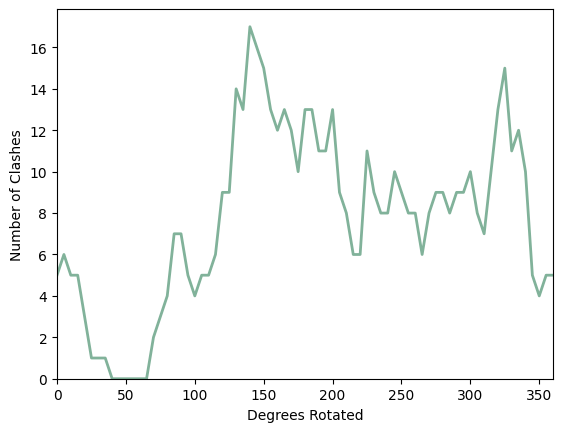

In [11]:
plt.plot(all_degrees_rotated,all_substrate_rotation_clashes[0],color='#81b29a',linewidth=2)
plt.xlabel('Degrees Rotated')
plt.ylabel('Number of Clashes')
plt.xlim(0,360)
plt.ylim(bottom=0)

In [ ]:
'''
num_samples = 5
divider = len(all_zero_angles)//num_samples
while divider <= 1 and num_samples != 0:
    num_samples -= 1
    divider = len(all_zero_angles)//num_samples

sample_indexes = [i for i in range(0,len(all_zero_angles)) if i%divider == 0]
angles_to_test = [all_zero_angles[i] for i in sample_indexes]

for curr_angle in angles_to_test:
    min_rotated_complex = rotate_atoms(complex.copy(), atom1_index, atom2_index, atoms_to_rotate, curr_angle)
    all_substrate_rotation_clashes.append(all_clashes)
    # output all necessary files
    receptor = min_rotated_complex.select_atoms("not resname INI and not resname WAT")
    receptor_dir = output_dir + "complexes/" + file_start + '/' + 'angle_' + str(curr_angle) + '/'
    receptor_file_name = "receptor.pdb"
    write_universe(receptor_dir, receptor_file_name, receptor)
    edit_protein_files(receptor_dir,receptor_file_name)
    
    # output the water
    try:
        water = min_rotated_complex.select_atoms(f"resname WAT")
        water_dir = output_dir + "complexes/" + file_start + '/' + 'angle_' + str(curr_angle) + '/'
        water_file_name = "water.pdb"
        write_universe(water_dir,water_file_name,water)
    except:
        print('No water to write')
    ini_final = min_rotated_complex.select_atoms("resname INI")
    ini_dir = output_dir + "complexes/" + file_start + '/' + 'angle_' + str(curr_angle) + '/'
    ini_file_name = "ini.pdb"
    write_universe(ini_dir, ini_file_name, ini_final)
'''